<a href="https://colab.research.google.com/github/acg12/corona-disease-detector/blob/master/experiments/Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openpyxl
!pip install kaggle

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split

# For visualizing images
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# For augmenting data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
import tensorflow_hub as hub
from sklearn.model_selection import StratifiedKFold

# For evaluation
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import os

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 735M/745M [00:03<00:00, 258MB/s]
100% 745M/745M [00:03<00:00, 245MB/s]


In [6]:
!unzip -q /content/covid19-radiography-database.zip

In [7]:
covid_df = pd.read_excel("/content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx")
normal_df = pd.read_excel("/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx")

In [8]:
covid_df['TARGET'] = 'Positive'
normal_df['TARGET'] = 'Negative'
normal_df.head()

,FILE NAME,FORMAT,SIZE,URL,TARGET
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative


In [9]:
covid_df['FILE NAME'] = covid_df.apply(lambda x: "COVID/" + x['FILE NAME'] + "." + str.lower(x['FORMAT']), axis=1)
normal_df['FILE NAME'] = normal_df.apply(lambda x: "Normal/" + str.capitalize(x['FILE NAME']) + "." + str.lower(x['FORMAT']), axis=1)
normal_df.head()

,FILE NAME,FORMAT,SIZE,URL,TARGET
0,Normal/Normal-1.png,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
1,Normal/Normal-2.png,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
2,Normal/Normal-3.png,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
3,Normal/Normal-4.png,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative
4,Normal/Normal-5.png,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Negative


In [10]:
df = pd.concat([normal_df[['FILE NAME', 'TARGET']], 
                covid_df[['FILE NAME','TARGET']]], ignore_index=True)
df.head()

,FILE NAME,TARGET
0,Normal/Normal-1.png,Negative
1,Normal/Normal-2.png,Negative
2,Normal/Normal-3.png,Negative
3,Normal/Normal-4.png,Negative
4,Normal/Normal-5.png,Negative


In [11]:
train, test = train_test_split(df, test_size=0.2, stratify=df['TARGET'], random_state=42)
print(train.shape)
print(test.shape)

(11046, 2)
(2762, 2)


In [12]:
train_df, valid_df = train_test_split(train, test_size=0.2, stratify=train['TARGET'], random_state=42)
print(train_df.shape)
print(valid_df.shape)

(8836, 2)
(2210, 2)


In [13]:
DATA_DIR = "/content/COVID-19_Radiography_Dataset"
IMAGE_SIZE = (224, 224)

non_aug_gen = ImageDataGenerator(rescale=1/255.)
aug_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

aug_train = aug_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=DATA_DIR,
    x_col='FILE NAME',
    y_col='TARGET',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

non_aug_valid = non_aug_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=DATA_DIR,
    x_col='FILE NAME',
    y_col='TARGET',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

test_valid_gen = non_aug_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=DATA_DIR,
    x_col='FILE NAME',
    y_col='TARGET',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False
)

test_test_gen = non_aug_gen.flow_from_dataframe(
    dataframe=test,
    directory=DATA_DIR,
    x_col='FILE NAME',
    y_col='TARGET',
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False
)

Found 8836 validated image filenames belonging to 2 classes.
Found 2210 validated image filenames belonging to 2 classes.
Found 2210 validated image filenames belonging to 2 classes.
Found 2762 validated image filenames belonging to 2 classes.


In [14]:
def create_model(model_url, num_classes=1):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
    should be equal to number of target classes, default 10.

    Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # freeze the underlying patterns
                                          name='feature_extraction_layer',
                                          input_shape=(224, 224, 3,)) # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
      feature_extractor_layer, # use the feature extraction layer as the base
      layers.BatchNormalization(),
      layers.Dense(128),
      layers.Activation('elu'),
      layers.Dropout(0.2),
      layers.BatchNormalization(),
      layers.Dense(128),
      layers.Activation('elu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
    ])

    return model

In [15]:
efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'

In [16]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc', curve='ROC')
]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint('model_baseline.h5', save_best_only=True, monitor='val_loss')]

In [17]:
# Add reduced LR to callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=4,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)
checkpoint_eff = tf.keras.callbacks.ModelCheckpoint('model_efficientnet_modif.h5', save_best_only=True, monitor='val_loss')

In [18]:
tf.random.set_seed(42)

# Build model
model_efficientnet = create_model(efficientnetv2_url)

# Compile model
model_efficientnet.compile(loss='binary_crossentropy',
                           optimizer=Adam(),
                           metrics=metrics)

model_efficientnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [19]:
# Train the model
history_efficientnet = model_efficientnet.fit(aug_train, epochs=30,
                                              validation_data=non_aug_valid,
                                              steps_per_epoch=len(aug_train),
                                              validation_steps=len(non_aug_valid),
                                              callbacks=[reduce_lr, checkpoint_eff])

np.save('history_efficientnet_modif.npy', history_efficientnet.history)

Epoch 1/30
277/277 [==============================] - 146s 469ms/step - loss: 0.2712 - tp: 1813.0000 - fp: 482.0000 - tn: 6040.0000 - fn: 501.0000 - accuracy: 0.8888 - precision: 0.7900 - recall: 0.7835 - auc: 0.9385 - val_loss: 0.1660 - val_tp: 487.0000 - val_fp: 43.0000 - val_tn: 1588.0000 - val_fn: 92.0000 - val_accuracy: 0.9389 - val_precision: 0.9189 - val_recall: 0.8411 - val_auc: 0.9751 - lr: 0.0010
Epoch 2/30
277/277 [==============================] - 127s 460ms/step - loss: 0.1933 - tp: 1908.0000 - fp: 256.0000 - tn: 6266.0000 - fn: 406.0000 - accuracy: 0.9251 - precision: 0.8817 - recall: 0.8245 - auc: 0.9661 - val_loss: 0.1400 - val_tp: 487.0000 - val_fp: 24.0000 - val_tn: 1607.0000 - val_fn: 92.0000 - val_accuracy: 0.9475 - val_precision: 0.9530 - val_recall: 0.8411 - val_auc: 0.9829 - lr: 0.0010
Epoch 3/30
277/277 [==============================] - 128s 461ms/step - loss: 0.1795 - tp: 1958.0000 - fp: 264.0000 - tn: 6258.0000 - fn: 356.0000 - accuracy: 0.9298 - precision: 0

In [20]:
# Plot the validation and training data separately
def plot_learning_curves(*histories):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    fig = make_subplots(rows=3, cols=1, subplot_titles=('Loss', 'Recall', 'AUC'))
    for history in histories:
        loss = history[1].history.get('loss')
        val_loss = history[1].history.get('val_loss')

        auc = history[1].history.get('auc')
        val_auc = history[1].history.get('val_auc')

        recall = history[1].history.get('recall')
        val_recall = history[1].history.get('val_recall')

        epochs = np.arange(1, len(history[1].history.get('loss')) + 1)

        fig.add_trace(go.Scatter(x=epochs, y=loss, name=history[0] + " train"), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=val_loss, name=history[0] + " val"), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=recall, name=history[0] + " train"), row=2, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=val_recall, name=history[0] + " val"), row=2, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=auc, name=history[0] + " train"), row=3, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=val_auc, name=history[0] + "val"), row=3, col=1)

    # Update xaxis properties
    fig.update_xaxes(title_text="Epochs", row=1, col=1)
    fig.update_xaxes(title_text="Epochs", row=2, col=1)
    fig.update_xaxes(title_text="Epochs", row=3, col=1)

    # Update yaxis properties
    fig.update_yaxes(title_text="Loss", row=1, col=1)
    fig.update_yaxes(title_text="Recall", row=2, col=1)
    fig.update_yaxes(title_text="AUC", row=3, col=1)

    fig.update_layout(title_text="Learning Curves", height=1500)

    fig.show()

In [21]:
plot_learning_curves(['EfficientNet_Modif', history_efficientnet])

In [22]:
def plot_roc_curve(*datas):
    fig = go.Figure()
    for data in datas:
        name = data[0]
        y_true = data[1]
        pred = data[2]

        fpr, tpr, _ = roc_curve(y_true, pred)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name))

    fig.update_yaxes(title_text="TPR")
    fig.update_xaxes(title_text="FPR")
    fig.update_layout(title_text="ROC Curve")
    fig.show()

In [63]:
def evaluate_model(y_true, pred, threshold=0.5):
    pred_new = [1 if i > threshold else 0 for i in pred]

    # Print classification report
    print('===== Classification Report ======')
    print(classification_report(y_true, pred_new))
    print()

    # Print confusion matrix
    data = {
        'y_Actual': y_true,
        'y_Predicted': pred_new
    }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    plt.title("Confusion Matrix")
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

    # Print other metrics
    print('===== Other Metrics =====')
    roc_auc = keras.metrics.AUC(curve='ROC')
    roc_auc.update_state(y_true, pred)
    print(f"ROC_AUC: {roc_auc.result().numpy()}")

In [45]:
test_valid_gen.reset()
pred_valid = model_efficientnet.predict(test_valid_gen)

y_valid = [0 if x == 'Negative' else 1 for x in valid_df['TARGET']]

plot_roc_curve(['EfficientNetV2-B0', y_valid, pred_valid])

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1631
           1       0.93      0.95      0.94       579

    accuracy                           0.97      2210
   macro avg       0.96      0.96      0.96      2210
weighted avg       0.97      0.97      0.97      2210




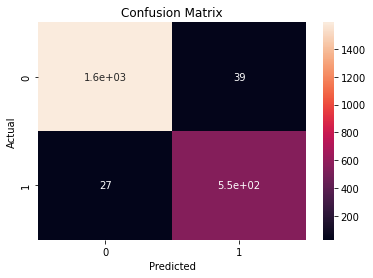

===== Other Metrics =====
ROC_AUC: 0.9931048154830933


In [64]:
# on validation data
evaluate_model(y_valid, pred_valid, threshold=0.2)

In [47]:
test_test_gen.reset()
pred_test = model_efficientnet.predict(test_test_gen)

y_test = [0 if x == 'Negative' else 1 for x in test['TARGET']]

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2039
           1       0.92      0.94      0.93       723

    accuracy                           0.96      2762
   macro avg       0.95      0.96      0.95      2762
weighted avg       0.96      0.96      0.96      2762




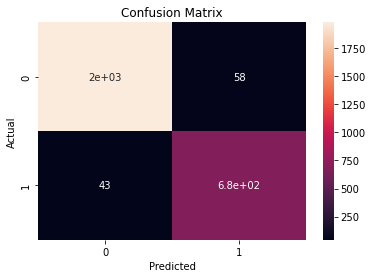

===== Other Metrics =====
ROC_AUC: 0.9916638731956482


In [66]:
# on test data
evaluate_model(y_test, pred_test, threshold=0.2)